In [1]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Vehicle Detection 

In this project different computer vision methods are used to detect vehicle in an image. This notebook contains the following steps:

1. Feature Extraction
2. Vehicle Classification
3. Sliding Window Search
4. Video - Implementation

## Preparation

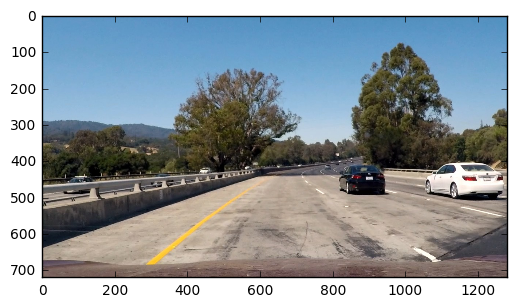

In [2]:
# Load test image
test_image = mpimg.imread('test_images/test1.jpg')
plt.imshow(test_image)

In [3]:
import glob

In [4]:
cars = glob.glob('datasets/vehicles/**/*.png', recursive=True)
noncars = glob.glob('datasets/non-vehicles/**/*.png', recursive=True)

In [5]:
cars[0]

'datasets/vehicles/GTI_Far/image0000.png'

## 1. Feature Extraction Methods

In [6]:
import cv2
import numpy as np
from skimage.feature import hog

In [7]:
def get_color_space_image(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

In [8]:
# If path is True then image is a placeholder for the path
def read_image(image, color_space, path=True):
    if path:
        image = mpimg.imread(image)
        
    return get_color_space_image(image, color_space)

In [9]:
feature_test_image = read_image(cars[0], 'RGB', path=True)
color_space_feature_test_image = read_image(feature_test_image, 'HSV', path=False)

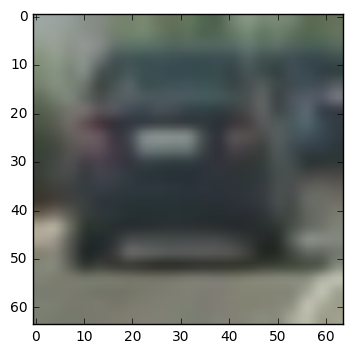

In [10]:
plt.imshow(feature_test_image)

### Binned Color Features

In [11]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

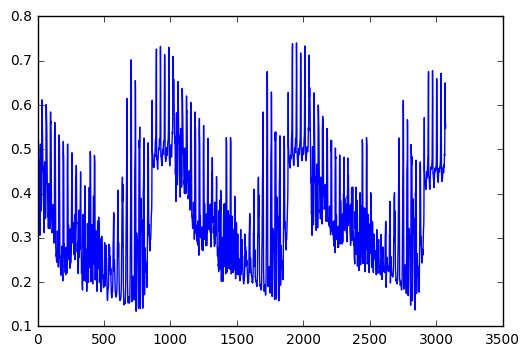

In [12]:
plt.plot(bin_spatial(feature_test_image))

### Color Histogram

In [13]:
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### HOG Features

In [14]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

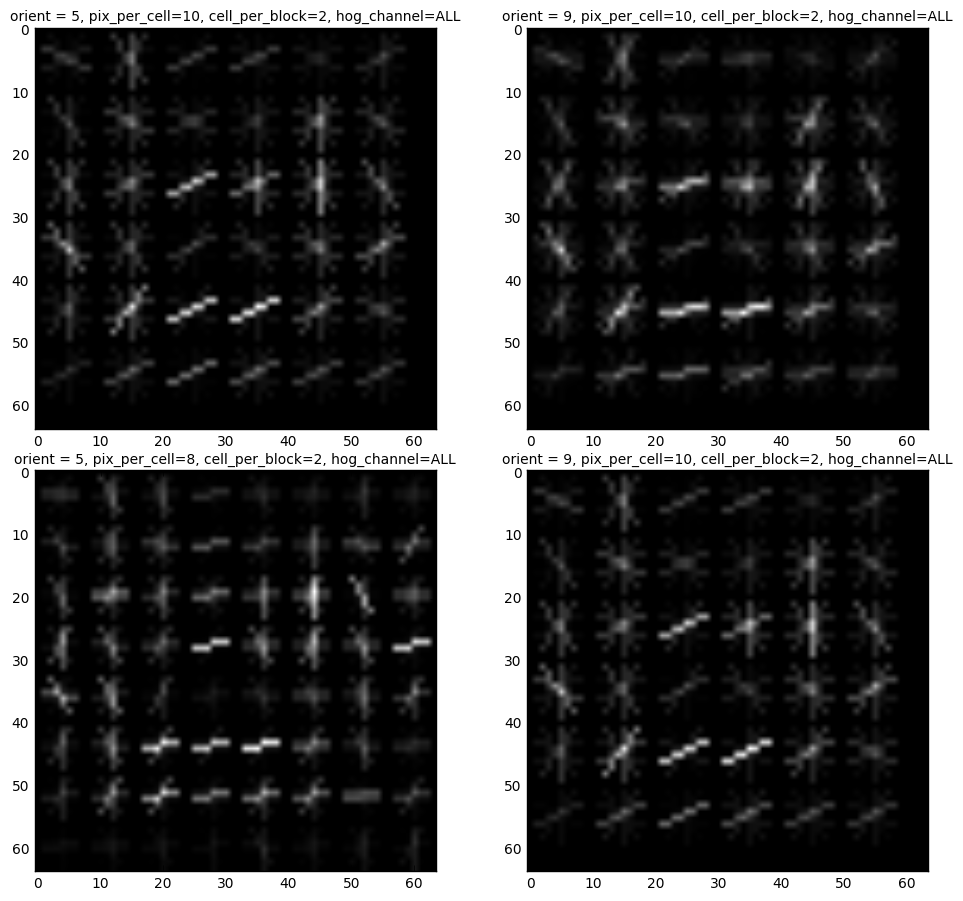

In [16]:
def sample_hog_image(orient, pix_per_cell, cell_per_block, hog_channel):
    color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

    features, hog_image = get_hog_features(color_space_feature_test_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    return hog_image

hog_image_1 = sample_hog_image(orient=5, pix_per_cell=10, cell_per_block = 2, hog_channel = "ALL")
hog_image_2 = sample_hog_image(orient=9, pix_per_cell=10, cell_per_block = 2, hog_channel = "ALL")
hog_image_3 = sample_hog_image(orient=5, pix_per_cell=8, cell_per_block = 2, hog_channel = "ALL")
hog_image_4 = sample_hog_image(orient=5, pix_per_cell=10, cell_per_block = 2, hog_channel = "ALL")


f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
f.tight_layout()
axes[0][0].imshow(hog_image_1, cmap='gray')
axes[0][0].set_title("orient = 5, pix_per_cell=10, cell_per_block=2, hog_channel=ALL", fontsize=10)
axes[0][1].imshow(hog_image_2, cmap='gray')
axes[0][1].set_title("orient = 9, pix_per_cell=10, cell_per_block=2, hog_channel=ALL", fontsize=10)
axes[1][0].imshow(hog_image_3, cmap='gray')
axes[1][0].set_title("orient = 5, pix_per_cell=8, cell_per_block=2, hog_channel=ALL", fontsize=10)
axes[1][1].imshow(hog_image_4, cmap='gray')
axes[1][1].set_title("orient = 9, pix_per_cell=10, cell_per_block=2, hog_channel=ALL", fontsize=10)

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
def extract_features(feature_image, spatial_size=(32, 32),
                          hist_bins=32, orient=9,
                          pix_per_cell=8, cell_per_block=2, hog_channel=0,
                          spatial_feat=False, hist_feat=False, hog_feat=False):

    spatial_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)

    hist_features = []
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)

    hog_features  = []
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=False))
            hog_features = np.ravel(hog_features)

        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=False).ravel()

        # Append the new feature vector to the features list

    file_features = np.hstack((spatial_features, hist_features, hog_features))
    return file_features

def extract_features_of_images(images, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=False, hist_feat=False, hog_feat=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    
    print("Spatial feature: " + str(spatial_feat))
    print("Hist feature: " + str(hist_feat))
    print("Hog feature: " + str(hog_feat))
    for image in images:
        # Read in each one by one
        feature_image = get_color_space_image(image, color_space)

        file_features = extract_features(feature_image, spatial_size, hist_bins, orient,
                                              pix_per_cell, cell_per_block, hog_channel,
                                              spatial_feat, hist_feat, hog_feat)

        features.append(file_features)
    # Return list of feature vectors
    return features

In [18]:
def sample_extraction():
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    feature_extracted_test_image = extract_features(feature_test_image, spatial_size,
                              hist_bins, orient,
                              pix_per_cell, cell_per_block, hog_channel,
                              spatial_feat, hist_feat, hog_feat)
    return feature_extracted_test_image
test_extraction = sample_extraction()
test_extraction.shape

(5472,)

# 2. Vehicle Classification

In [19]:
color_space = 'HSV' 
orient = 5  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = "ALL" 

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [20]:
def read_images(images, color_space='RGB'):
    read = []
    for img in images:
        img = read_image(img, color_space, True)
        read.append(img)
    return read

cars_images = read_images(cars)
noncars_image = read_images(noncars)

In [21]:
car_features = extract_features_of_images(cars_images, color_space, spatial_size, 
                                          hist_bins, orient, pix_per_cell, cell_per_block, 
                                          hog_channel, spatial_feat, hist_feat, hog_feat)
noncar_features = extract_features_of_images(noncars_image, color_space, spatial_size, 
                                          hist_bins, orient, pix_per_cell, cell_per_block, 
                                          hog_channel, spatial_feat, hist_feat, hog_feat)

Spatial feature: False
Hist feature: True
Hog feature: True
Spatial feature: False
Hist feature: True
Hog feature: True


In [22]:
from sklearn.preprocessing import StandardScaler
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print(X_scaler)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [23]:
from sklearn.model_selection import train_test_split
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### Train Classifier

In [24]:
from sklearn.svm import LinearSVC
import time
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 5 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2988
7.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9772


# 3. Sliding Window Search

In [28]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [29]:
image = plt.imread('test_images/test5.jpg')
draw_image = np.copy(image)

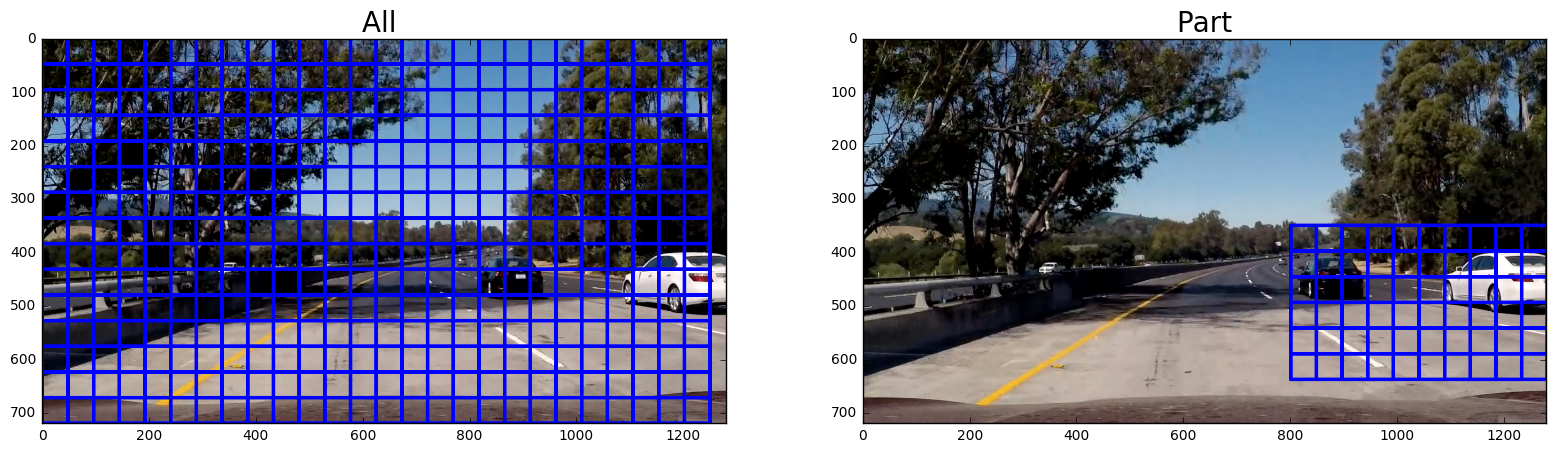

In [31]:
windows_all = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[0, image.shape[0]], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))  
windows = slide_window(image, x_start_stop=[800, 1280], y_start_stop=[350, 650], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

fig = plt.figure(figsize=(30, 15))
plt.subplot(131)
plt.title('All ', fontsize=20)
plt.imshow(draw_boxes(draw_image, windows_all))

plt.subplot(132)
plt.title('Part', fontsize=20)
plt.imshow(draw_boxes(draw_image, windows))
#plt.imshow(draw_boxes(draw_image, windows))

In [32]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        feature_image = get_color_space_image(test_img, color_space)

        features = extract_features(feature_image, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [33]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    

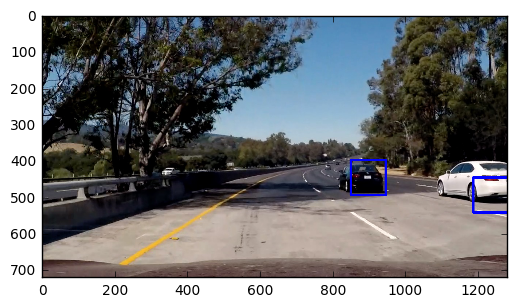

In [34]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

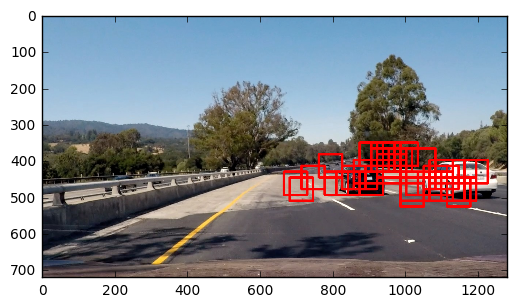

In [35]:
def resize_img(img, scale):
    imshape = img.shape
    xy = (np.int(imshape[1]/scale), np.int(imshape[0]/scale))
    return cv2.resize(img, xy)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)

    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1], x_start_stop[0]: x_start_stop[1],:]
    #ctrans_tosearch = get_color_space_image(img, color_space)
    ctrans_tosearch = get_color_space_image(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch = resize_img(ctrans_tosearch, scale)
        #plt.imshow(ctrans_tosearch, cmap='gray')

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    
    bbox = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
                        
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1) 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
  
            hist_features = color_hist(subimg, nbins=hist_bins)
            extracted = np.hstack((hist_features, hog_features[0]))

            test_features = X_scaler.transform(extracted.reshape(1, -1))   
            #np.concatenate()
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                xy1 = (xbox_left+x_start_stop[0], ytop_draw+ystart)
                xy2 = (xbox_left+win_draw+x_start_stop[0],ytop_draw+win_draw+ystart)     
                #if xy1[1] < ystop and xy2[1] < ystop:
                    
                bbox.append((xy1, xy2))
                cv2.rectangle(draw_img, xy1, xy2,(255,0,0),6) 
    
        
    return draw_img, bbox
    
ystart = 350
ystop = 656
scale = 1
    
image = plt.imread("test_images/test4.jpg")

x_start_stop = (600, image.shape[1])
y_start_stop = (ystart, image.shape[1])
out_img, box_list = find_cars(image, color_space, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [36]:
def find_multiple_cars(image, color_space, 
                       ystart, ystop, scale, 
                       svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins):
    scales = [1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3, 3.3]
    
    box_list = []
    
    for scale in scales:
        
        x_start_stop = (600, image.shape[1])
        y_start_stop = (ystart, image.shape[1])

    
    
        _, detected_boxes = find_cars(image, color_space, x_start_stop, 
                           y_start_stop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for box in detected_boxes:
            box_list.append(box)
        
    return box_list
        
    
box_list = find_multiple_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# 4. Video - Implementation

In [37]:
from scipy.ndimage.measurements import label

## Heatmap

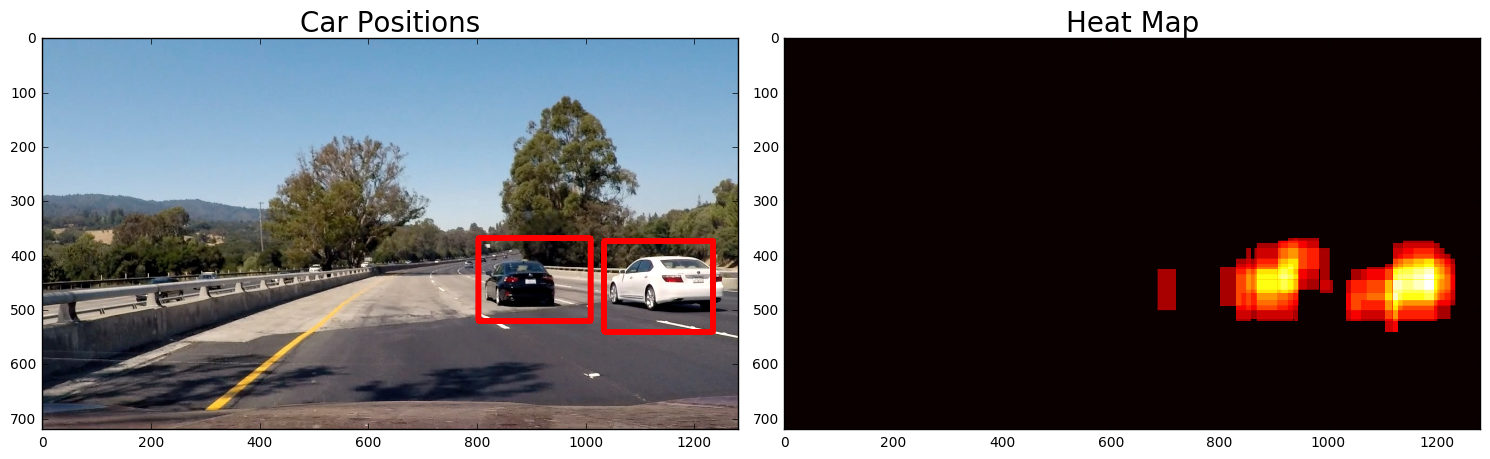

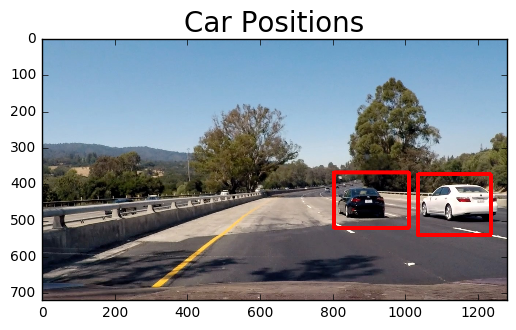

In [38]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

    
def draw_labeled_bboxes(img, labels):
    box_heat = []
    
    # Iterate through all detected cars    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        
        if bbox[1][0]- bbox[0][0]  > 50 and bbox[0][0] >500:
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 10)
        
        box_heat.append(bbox)
    # Return the image
    return img, box_heat


def heatmap(img, box_list, threshold=1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, boxes, heatmap

draw_img, boxes, heat_map = heatmap(image, box_list, 3)
    
fig = plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=20)
plt.subplot(122)
plt.imshow(heat_map, cmap='hot')
plt.title('Heat Map', fontsize=20)
fig.tight_layout()
plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=20)

In [39]:
def heat_map_rectangles(ori_img, threshold=1):
    feature_image = get_color_space_image(ori_img, 'HSV')
    
    box_list = find_multiple_cars(feature_image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    draw_img, boxes, heat_map = heatmap(ori_img, box_list, 10)
    #plt.imshow(draw_img)
    return draw_img, heat_map

draw_img_1, heat_map_1 = heat_map_rectangles(plt.imread("test_images/test1.jpg"))
draw_img_2, heat_map_2 = heat_map_rectangles(plt.imread("test_images/test5.jpg"))
draw_img_3, heat_map_3 = heat_map_rectangles(plt.imread("test_images/test6.jpg"))
draw_img_4, heat_map_4 = heat_map_rectangles(plt.imread("test_images/test4.jpg"))

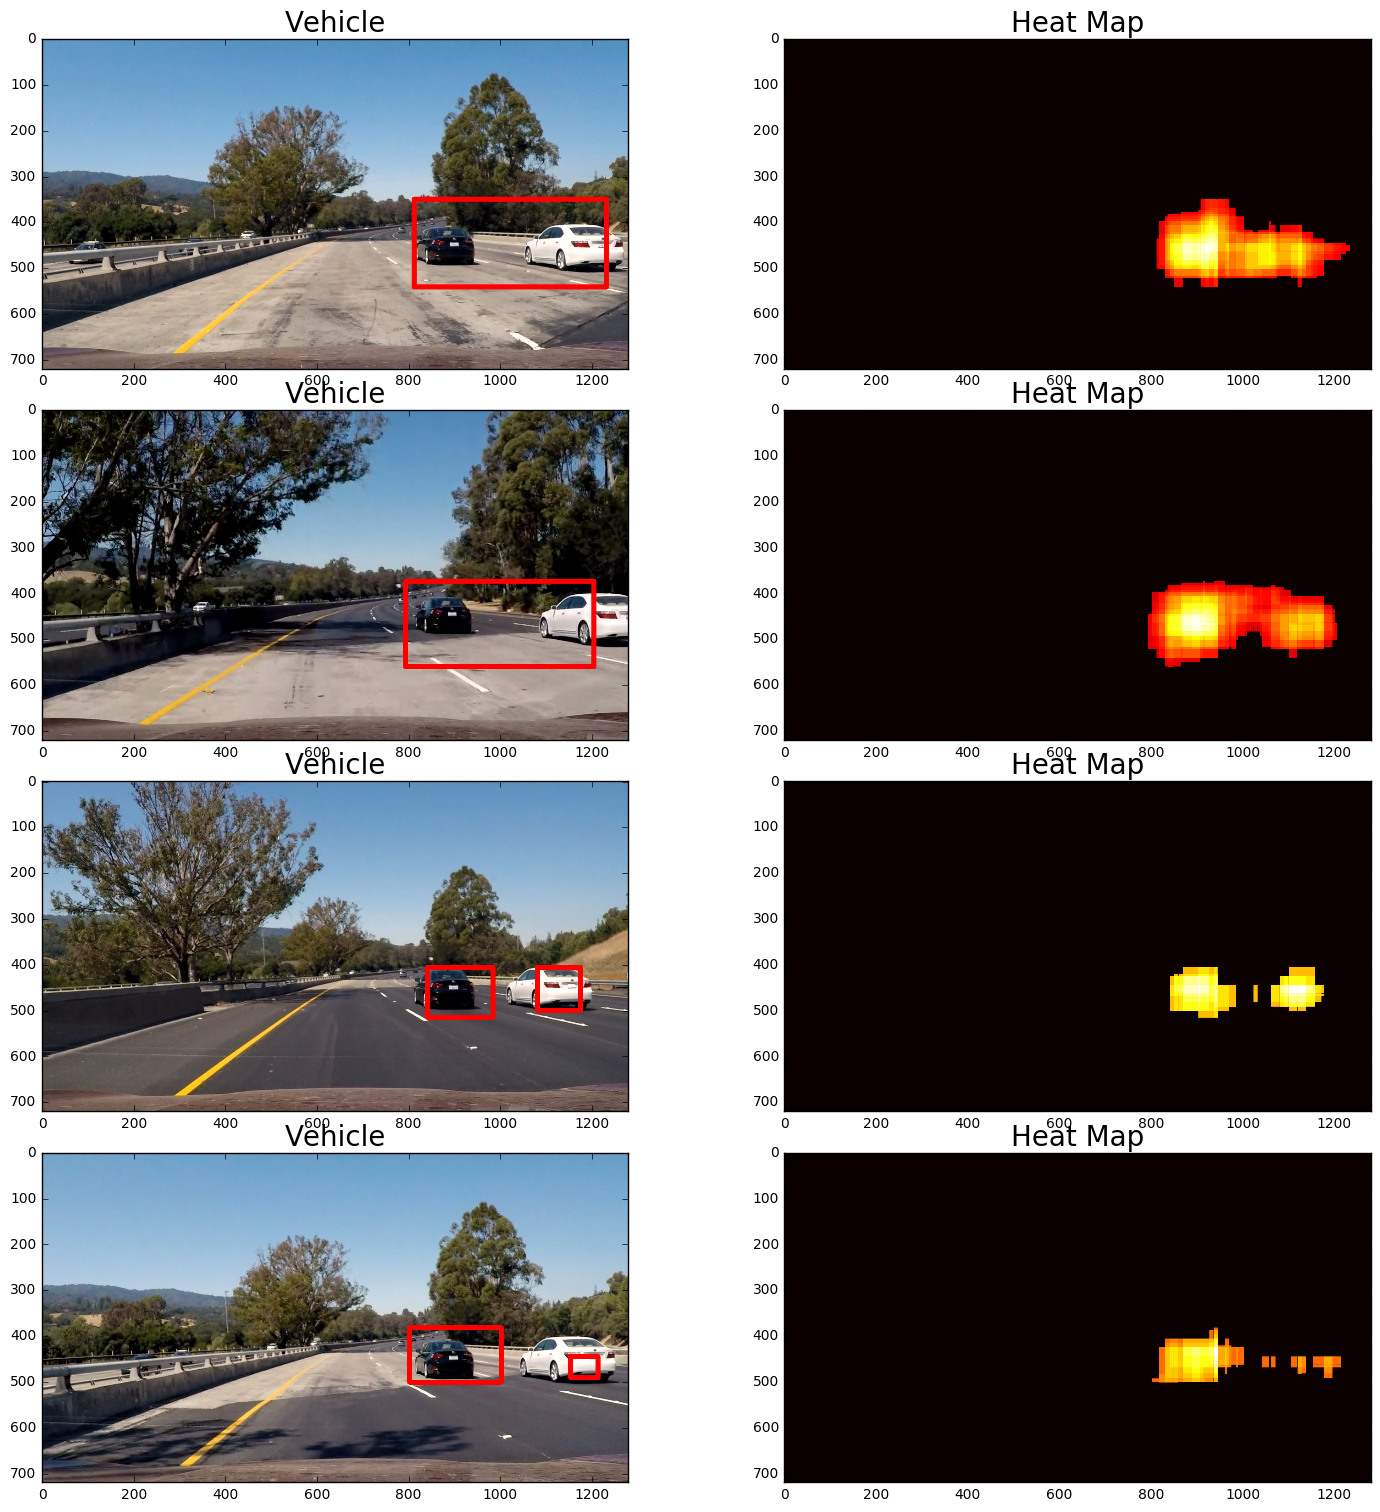

In [40]:
f, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 15))
f.tight_layout()
axes[0][0].imshow(draw_img_1)
axes[0][0].set_title("Vehicle", fontsize=20)
axes[0][1].imshow(heat_map_1, cmap='hot')
axes[0][1].set_title("Heat Map", fontsize=20)
axes[1][0].imshow(draw_img_2)
axes[1][0].set_title("Vehicle", fontsize=20)
axes[1][1].imshow(heat_map_2, cmap='hot')
axes[1][1].set_title("Heat Map", fontsize=20)
axes[2][0].imshow(draw_img_3)
axes[2][0].set_title("Vehicle", fontsize=20)
axes[2][1].imshow(heat_map_3, cmap='hot')
axes[2][1].set_title("Heat Map", fontsize=20)
axes[3][0].imshow(draw_img_4)
axes[3][0].set_title("Vehicle", fontsize=20)
axes[3][1].imshow(heat_map_4, cmap='hot')
axes[3][1].set_title("Heat Map", fontsize=20)


## Video 

In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:

def process_image(ori_img, threshold=1):
    feature_image = get_color_space_image(ori_img, 'HSV')
    
    box_list = find_multiple_cars(feature_image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    draw_img, boxes, heat_map = heatmap(ori_img, box_list, 10)
    #plt.imshow(draw_img)
    res = cv2.resize(heat_map, (256, 128))
    hot_color = np.zeros((128,256,3), dtype=np.int)

    hot_color[:,:,0] = res * 255/38
    draw_img[:128, :256] = hot_color
    return draw_img
    #return img

In [146]:
project_output = 'project_video_detection.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(44, 47) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_detection.mp4
[MoviePy] Writing video project_video_detection.mp4


100%|█████████▉| 1260/1261 [21:04<00:01,  1.05s/it]    | 1/1261 [00:01<21:08,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection.mp4 

CPU times: user 20min 47s, sys: 24.2 s, total: 21min 12s
Wall time: 21min 4s


In [147]:
HTML("""
<video width="920" height="600" controls>
  <source src="{0}">
</video>
""".format(project_output))